<a href="https://colab.research.google.com/github/noelmt7/Sentiment_Analysis_Tweets-/blob/main/RESEARCH_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset : The dataset is a combination of 74,681 views from different people in Twitter media which includes 4 columns

1. Index : which indicates a number for each sample (not important)
2. Borderlands : which indicates a number of areas for each sample
3. Mode : The feeling of that person about the text which has shared
4. Text : The texture that view that person has shared.

In [1]:
! pip install spacy

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import random

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer , TweetTokenizer
from nltk.stem import WordNetLemmatizer ,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import spacy
import warnings

nlp = spacy.load("en_core_web_sm")
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv('/content/twitter_training.csv')
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [4]:
df.shape

(15836, 4)

In [5]:
df.isnull().sum()

2401                                                       0
Borderlands                                                0
Positive                                                   0
im getting on borderlands and i will murder you all ,    161
dtype: int64

In [6]:
df.describe(include = 'all')

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
count,15836.000000,15836,15836,15675
unique,NaN,7,4,14815
top,NaN,CallOfDutyBlackopsColdWar,Negative,
freq,NaN,2376,4674,37
mean,5597.146123,NaN,NaN,NaN
std,4482.730790,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,1878.000000,NaN,NaN,NaN
50%,2958.000000,NaN,NaN,NaN
75%,9321.000000,NaN,NaN,NaN


# **EDA**

In [7]:
df.rename(columns={'2401' : 'Index' , 'Borderlands': 'Land' , 'Positive' : 'Mode'
                   , "im getting on borderlands and i will murder you all ,": 'Tweets'}, inplace=True)

In [8]:
df.head(100)

,Index,Land,Mode,Tweets
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
...,...,...,...,...
95,2417,Borderlands,Negative,Grounded almost looked pretty cool even despit...
96,2417,Borderlands,Negative,Grounded looked cool despite the borderline un...
97,2417,Borderlands,Negative,"Grosskreutz looked pretty cool, even despite t..."
98,2417,Borderlands,Negative,Grounded almost looked pretty cool here despit...


In [9]:
def show_details(dataset):
    missed_values = dataset.isnull().sum()
    missed_values_percent = (dataset.isnull().sum()) / len(dataset)
    duplicated_values = dataset.duplicated().sum()
    duplicated_values_percent = (dataset.duplicated().sum()) / len(dataset)
    info_frame = pd.DataFrame({'Missed_Values' : missed_values ,
                              'Missed_Values %' :missed_values_percent,
                              'Duplicated values' :duplicated_values,
                              'Duplicated values %':duplicated_values_percent})
    return info_frame.T

In [10]:
show_details(df)

,Index,Land,Mode,Tweets
Missed_Values,0.00000,0.00000,0.00000,161.000000
Missed_Values %,0.00000,0.00000,0.00000,0.010167
Duplicated values,607.00000,607.00000,607.00000,607.000000
Duplicated values %,0.03833,0.03833,0.03833,0.038330


In [11]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
show_details(df)

,Index,Land,Mode,Tweets
Missed_Values,0.0,0.0,0.0,0.0
Missed_Values %,0.0,0.0,0.0,0.0
Duplicated values,0.0,0.0,0.0,0.0
Duplicated values %,0.0,0.0,0.0,0.0


In [12]:
print(f'The number of unique lands : {len(df.Land.unique())}')

df.Land.unique()

The number of unique lands : 7


array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2'], dtype=object)

In [13]:
lands =df.Land.value_counts()
lands.to_frame()

,Land
NBA2K,2299
Amazon,2249
CallOfDutyBlackopsColdWar,2242
Overwatch,2220
Borderlands,2205
Xbox(Xseries),2201
Dota2,1734


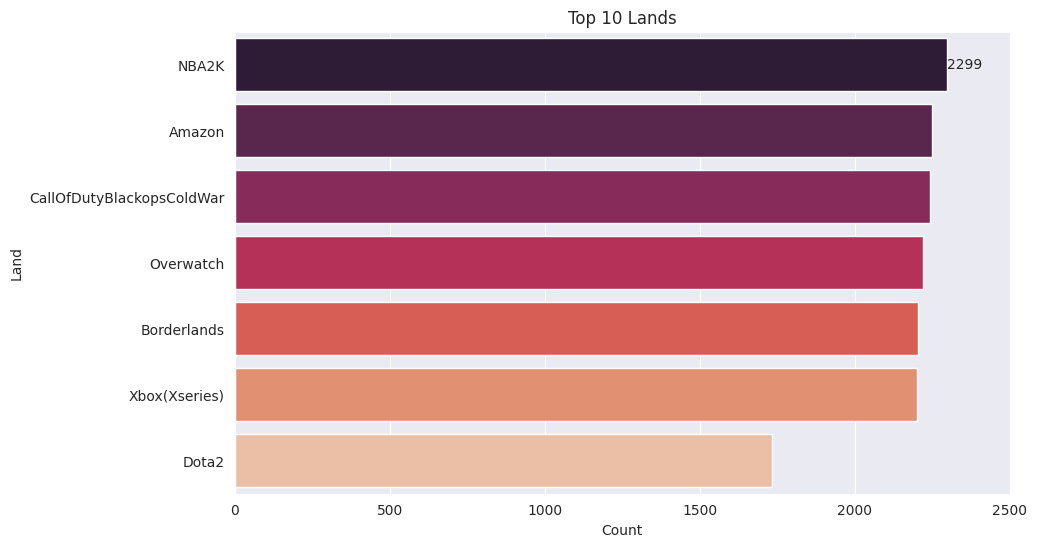

In [14]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
bar = sns.barplot(x=lands.values[:10] ,y=lands.index[:10] , palette='rocket')
bar.bar_label(bar.containers[0])
plt.title('Top 10 Lands')
plt.xlabel('Count')
plt.ylabel('Land')
plt.xlim(0 , 2500)
plt.show()

In [15]:
print(f'The unique values of Mode : {len(df.Mode.unique())}')
print(df.Mode.unique())

The unique values of Mode : 4
['Positive' 'Neutral' 'Negative' 'Irrelevant']


In [16]:
mode = df.Mode.value_counts()
mode.to_frame().T

,Negative,Positive,Neutral,Irrelevant
Mode,4497,4355,3496,2802


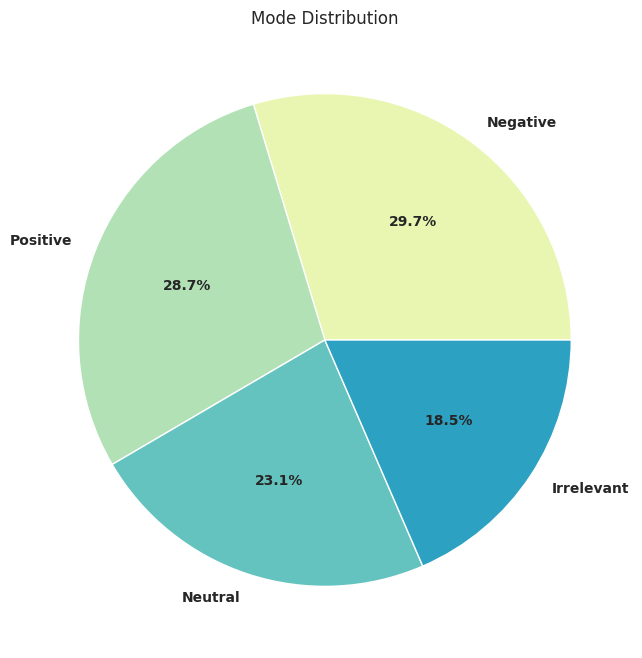

In [17]:
plt.figure(figsize=(10,8))
plt.pie(x = mode.values , labels=mode.keys() ,autopct="%1.1f%%" ,
textprops={"fontsize":10,"fontweight":"black"},colors=sns.color_palette("YlGnBu"))
plt.title('Mode Distribution')
plt.show()

In [18]:
pd.crosstab(df.Mode , df.Land).T.style.background_gradient( subset=['Negative'],cmap='Reds')\
.background_gradient(subset=['Positive'] , cmap='Greens')\
.background_gradient(subset=['Irrelevant'] , cmap='BuGn')


Mode,Irrelevant,Negative,Neutral,Positive
Land,,,,
Amazon,185,565,1197,302
Borderlands,238,415,581,971
CallOfDutyBlackopsColdWar,545,540,340,817
Dota2,313,566,428,427
NBA2K,175,1450,265,409
Overwatch,646,606,282,686
Xbox(Xseries),700,355,403,743


 - Here with re library we can replace a number of grammatically problems , verbal expressions.
 - Finally , all texts become lower mode and instead more than 1 space be just 1 space

In [19]:
def text_cleaner(tx):

    text = re.sub(r"won\'t", "would not", tx)
    text = re.sub(r"im", "i am", tx)
    text = re.sub(r"Im", "I am", tx)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\!\?\.\@]',' ' , text)
    text = re.sub(r'[!]+' , '!' , text)
    text = re.sub(r'[?]+' , '?' , text)
    text = re.sub(r'[.]+' , '.' , text)
    text = re.sub(r'[@]+' , '@' , text)
    text = re.sub(r'unk' , ' ' , text)
    text = re.sub('\n', '', text)
    text = text.lower()
    text = re.sub(r'[ ]+' , ' ' , text)

    return text

**POS:**
POS or Part Of Speech , the part of speech indicates how the word functions in meaning as well as grammatically within the sentence.
There are 8 parts in English (noun, pronoun, verb, adjective, adverb, preposition, conjunction, and interjection)
Understanding parts of speech is essential for determining the correct definition of a word when using the dictionary.

**Description**
with using of Spacy library and its amazing features (nlp = spacy.load("en_core_web_sm")) which is used for English language
I am going to show you POS in the particular sample

In [20]:
def make_corpus(kind):
    corpus = []
    for text in df.loc[df['Mode']==kind]['Tweets'].str.split():
        for word in text:
            corpus.append(word)
    return corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


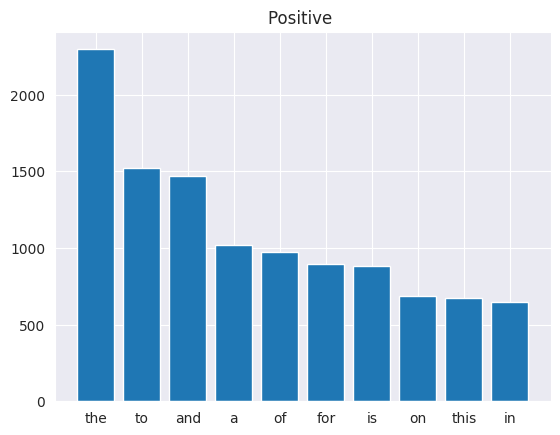

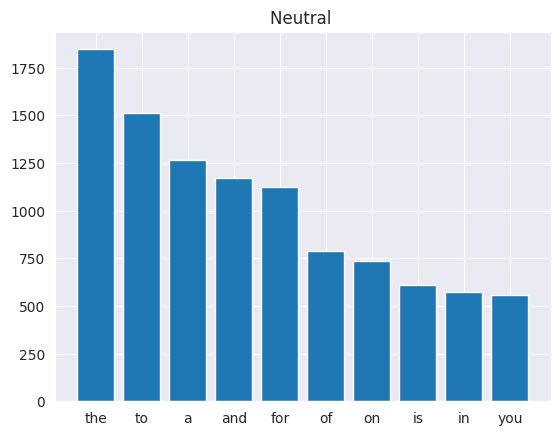

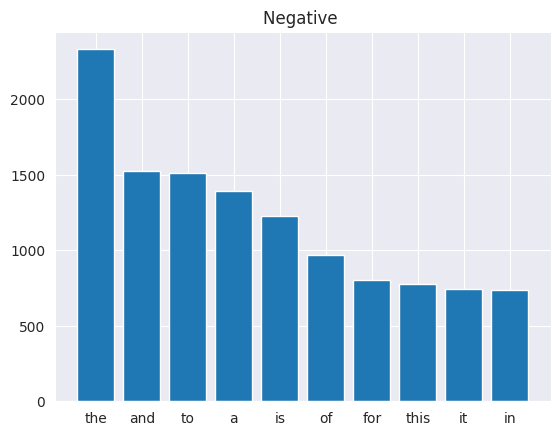

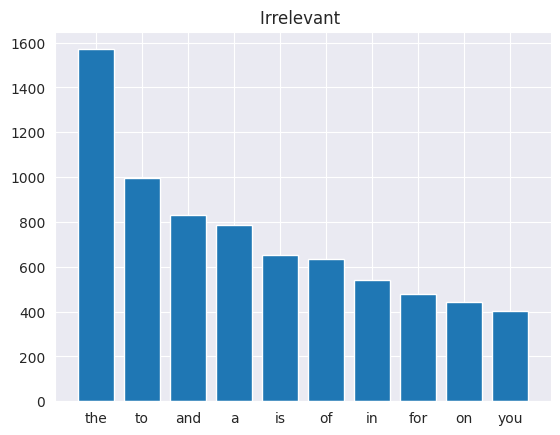

CPU times: user 1.9 s, sys: 386 ms, total: 2.29 s
Wall time: 2.05 s


In [21]:
%%time
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')
sentiments = list(df.Mode.unique())



for inx , value in enumerate(sentiments):

    corpus = make_corpus(value)

    dic = defaultdict(int)

    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]

    x, y = zip(*top)
    plt.title(f'{value} ')
    plt.bar(x , y)
    plt.show()

In [22]:
# # df['Text'] = df['Text'].apply(lambda x : clean_emoji(x))
# Tokenizer=RegexpTokenizer(r'\w+')
# df['Tweets'] = df['Tweets'].apply(lambda x : text_cleaner(x))
# df['Tweets']= df['Tweets'].apply(lambda x : Tokenizer.tokenize(x))
# df['Tweets'].to_frame()

**WordCloud**
word Cloud is just a data visualization technique used for representing text data in which the size of each word indicates its frequency or
importance.Now , I will show the most important words(common ones) exclude stopwords for each Mode.


In [23]:
%%time
positive_reviews = df[df['Mode'] == 'Positive']['Tweets']
pos = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(pos)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

NameError: name 'stopwords_list' is not defined

In [24]:
%%time
positive_reviews = df[df['Mode'] == 'Negative']['Tweets']
neg = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(neg)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

NameError: name 'stopwords_list' is not defined

In [25]:
%%time
positive_reviews = df[df['Mode'] == 'Neutral']['Tweets']
Neutral = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(Neutral)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Neutral Reviews')
plt.axis('off')
plt.show()

NameError: name 'stopwords_list' is not defined

**Descripton**
A number of fundamental statistics are shown below to know about corpus .such as , maximum , minimum length of texts ,
mean of length , std and the last calculation which is momentous is the number of words which we are required to have for each sample
we should not allow all words of each sample be in the review).For example, someone has a review with 797 words. so it is computiationally expensive and furthermore , it dosent allow our model to learn perfectly.Instead of all words , we are going to use a formula to keep 95% of data , but
with a samller amount of data for learning better and instead of those additional words we use a special character namely PAD becuase all sample
should have the same length. here , Mew + 2 sigma is 165.7 which we are going to use 166 words of each sample.

In [26]:

len_text = [len(tx) for tx in df['Tweets'].to_list()]
print(f'Max Length : {np.max(len_text)}')
print(f'Min Length : {np.min(len_text)}')
print(f'Mean Length : {round(np.mean(len_text),2)}')
print(f'Std Length : {round(np.std(len_text),2)}')
print(f'Mew + 2sigma : {round(np.mean(len_text)+ 2 *np.std(len_text),2)}')

Max Length : 692
Min Length : 1
Mean Length : 106.58
Std Length : 79.58
Mew + 2sigma : 265.75


In [27]:
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

Stemmer = PorterStemmer()

# Define the regular expression pattern to match non-alphanumeric characters
pattern = r'[^a-zA-Z0-9\s]'

# Assuming stopwords_list is defined or imported elsewhere in your code
stopwords_list = set(stopwords.words('english'))

def stopwords_cleaner(text, stopwords_list):
    # Remove symbols using regular expression substitution
    text = re.sub(pattern, '', text)
    # Stemming and removing stopwords
    words = [Stemmer.stem(word) for word in text.split() if word not in stopwords_list]
    cleaned_text = ' '.join(words)
    return cleaned_text

# Assuming df['tweets'] contains the text data you want to clean
# Apply the stopwords_cleaner function to the 'tweets' column of the DataFrame
# Make sure to pass the stopwords_list as an argument
df['Tweets'] = df['Tweets'].apply(lambda x: stopwords_cleaner(x, stopwords_list))
df


,Index,Land,Mode,Tweets
0,2401,Borderlands,Positive,i come border i kill
1,2401,Borderlands,Positive,im get borderland kill
2,2401,Borderlands,Positive,im come borderland murder
3,2401,Borderlands,Positive,im get borderland 2 murder
4,2401,Borderlands,Positive,im get borderland murder
...,...,...,...,...
15827,3108,Dota2,Negative,wtf
15831,3108,Dota2,Negative,she wtf
15833,3109,Dota2,Irrelevant,icymi blastdota find sponsor kitkat we look fo...
15834,3109,Dota2,Irrelevant,icymi blastdota find sponsor kitkat we look fo...


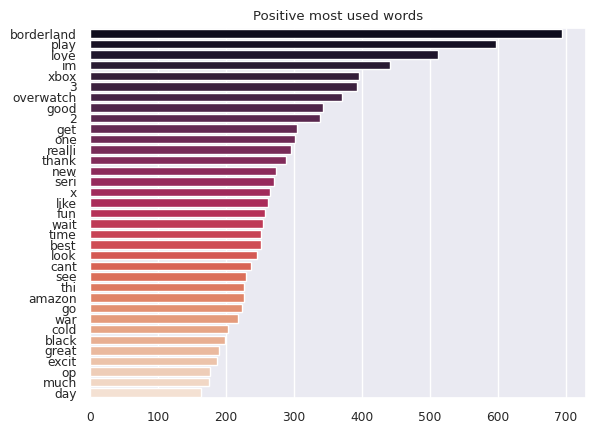

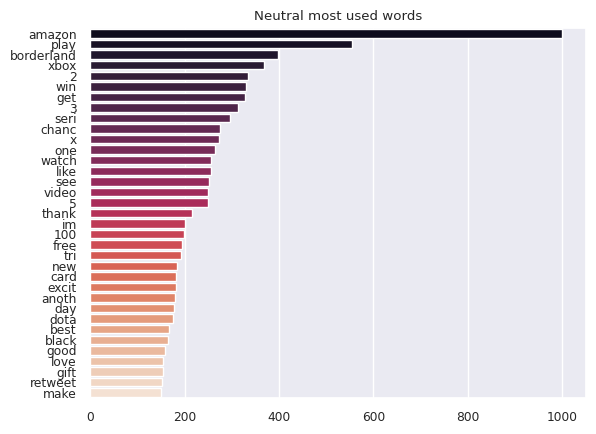

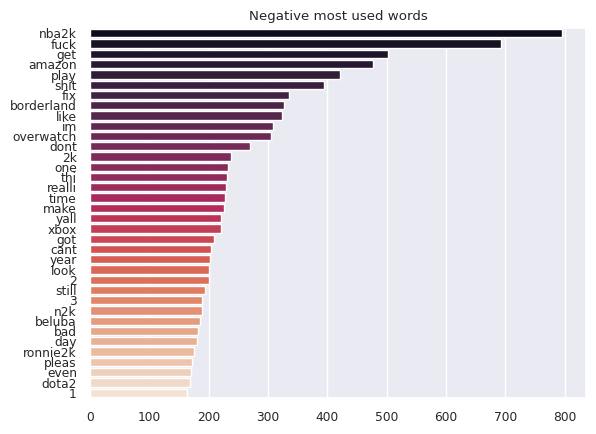

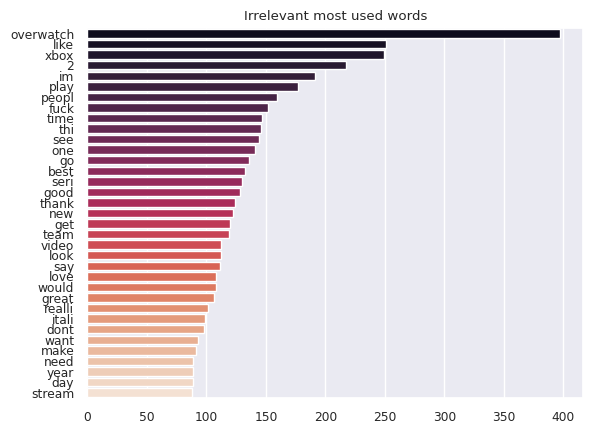

CPU times: user 3.15 s, sys: 388 ms, total: 3.54 s
Wall time: 3.56 s


In [28]:
%%time
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Define the word to exclude
exclude_word = "game"

sns.set(font_scale=0.8)
for inx, value in enumerate(sentiments):
    counter = Counter(make_corpus(value))
    most_common = counter.most_common()

    x = []
    y = []

    for word, count in most_common[:40]:
        if word not in stop and word != exclude_word:  # Exclude the word "game"
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, orient='h', palette='rocket')
    plt.title(f'{value} most used words')
    plt.show()


Creating a column named sentiments and instead of Positive , Negative we put 1 and 0 , instead of Neutral and Irrelevant we put 2. It means that underestanding Positive and Negative reviews is much more important for use rather that neutral and Irrelevant ones.(Just for decreasing the calsses and increasing the accuracy for finding Positive and Negative ones) however , we are able to classify each one of them without mixing , but of curse the accuracy will decrease noticeably.

In [29]:
df['sentiments'] = df['Mode'].replace({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 2 })

In [30]:
df.sample(10)

,Index,Land,Mode,Tweets,sentiments
13431,8705,NBA2K,Negative,nba2k worst scale game scenario 2019 2020 no d...,0
6343,291,Amazon,Neutral,a power insight portrait uniqu american landsc...,2
10174,12951,Xbox(Xseries),Positive,one section xbox alway lead kudo alreadi provi...,1
13256,8676,NBA2K,Positive,im gonna use pink diamond moment nba2kmyteam,1
8328,9429,Overwatch,Negative,give men nice butt,0
15257,3012,Dota2,Irrelevant,my bad,2
10325,12978,Xbox(Xseries),Negative,i cant even mad im fuck idiot,0
7270,9250,Overwatch,Negative,,0
7925,9362,Overwatch,Negative,broyouwack lie even origin overwatch game disk...,0
1157,2604,Borderlands,Irrelevant,alway good ashlyburch perform aloy horizon zer...,2


Now , we are going to create a customer class to show len and item.

In [31]:
class Dataset:
    def __init__(self,text,sentiment):
        self.text = text
        self.sentiment = sentiment

    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = self.text[item,:]
        target = self.sentiment[item]
        return {
            "text": torch.tensor(text,dtype = torch.long),
            "target": torch.tensor(target,dtype = torch.long)
        }



We require helper functions to help us reading word vectors(we have a vord vector to give our model to understand the distant meaning of each words
and by that we can improve our model accuracy. There are many word vectors whcih I will use glove.6B.300d 300 is the dimention.you can use less
ones. More is better understanding but computationally higher.)and them another function to help us create embedding matrix for our corpus words.

In [32]:
def load_vectors(fname):
    fin = open(fname , encoding="utf8")
    data = {}
    for line in fin:
        tokens = line.split()
        data[tokens[0]] = np.array([float(value) for value in tokens[1:]])

    return data

In [33]:
def create_embedding_matrix(word_index,embedding_dict):

    embedding_matrix = np.zeros((len(word_index)+1,300))
    for word, i in word_index.items():
        if word in embedding_dict:
            embedding_matrix[i] = embedding_dict[word]

    return embedding_matrix

<hr>

#***MODEL***

<center>
<img src="https://miro.medium.com/v2/resize:fit:764/1*6QnPUSv_t9BY9Fv8_aLb-Q.png" width=900 height=400 />
</center>

Bidirectional LSTM (BiLSTM) is a recurrent neural network used primarily on natural language processing. Unlike standard LSTM, the input flows in both directions, and it’s capable of utilizing information from both sides. It’s also a powerful tool for modeling the sequential dependencies between words and phrases in both directions of the sequence.

In summary, BiLSTM adds one more LSTM layer, which reverses the direction of information flow. Briefly, it means that the input sequence flows backward in the additional LSTM layer. Then we combine the outputs from both LSTM layers in several ways, such as average, sum, multiplication, or concatenation.

In [34]:
class sentimentBiLSTM(nn.Module):
#inherited from nn.Module

    def __init__(self, embedding_matrix, hidden_dim, output_size):

        #initializing the params by initialization method
        super(sentimentBiLSTM, self).__init__()
        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        num_words = self.embedding_matrix.shape[0]
        embed_dim = self.embedding_matrix.shape[1]
        # craetinh embedding layer
        self.embedding = nn.Embedding(num_embeddings=num_words,embedding_dim=embed_dim)

        ## initializes the weights of the embedding layer to the pretrained embeddings in
        ## embedding_matrix. It first converts embedding_matrix to a PyTorch tensor and
        ## wraps it in an nn.Parameter object, which makes it a learnable parameter of the model.
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_dim,hidden_dim,bidirectional=True,batch_first=True)

        #it is multuplied by 2 becuase it is bi_directional if one-sided it didnt need.
        self.fc = nn.Linear(hidden_dim*2, output_size)


    #we need a forward function to model calculate the cost and know how bad the params is .
    # However , it can be written in a line of code but if we want to track it it is easier way.
    def forward(self, x):


        embeds = self.embedding(x)
        lstm_out,_ = self.lstm(embeds)
        lstm_out = lstm_out[:, -1]
        out = self.fc(lstm_out)

        return out

In [35]:
y = df.sentiments.values
train_df,test_df = train_test_split(df,test_size = 0.2, stratify = y)

**Descripton**

Max_length as mew + 2sigma = 167
Batch size is a number that detremined based on your system 16-32-64...
Hidden_dimention for the model will be 64
output is the number of classes which we have (len(classes))
Also check if Cuda is available we put our system on GPU else CPU

In [36]:
MAX_LEN = 167
BATCH_SIZE = 32
hidden_dim = 64
output_size = 3


if torch.cuda.is_available():

       device = torch.device("cuda")

else:
       device = torch.device("cpu")


print(f'Current device is {device}')


Current device is cuda


Descripton
now , we need to convert each sample to a readable way and deleting all extra words more than 167 and put PAD character instead
we use texts_to_sequences function to do that.and then using DataLoader to read data for both Train and Test.

In [37]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.Tweets.values.tolist())

xtrain = tokenizer.texts_to_sequences(train_df.Tweets.values)
xtest = tokenizer.texts_to_sequences(test_df.Tweets.values)
xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain,maxlen = MAX_LEN)
xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest,maxlen = MAX_LEN)
train_dataset = Dataset(text=xtrain,sentiment=train_df.sentiments.values)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,drop_last=True)
valid_dataset = Dataset(text=xtest,sentiment=test_df.sentiments.values)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_SIZE,drop_last=True)

In [38]:
# check a batch of data
one_batch = next(iter(train_loader))
one_batch

{'text': tensor([[   0,    0,    0,  ...,  542,   93, 2300],
         [   0,    0,    0,  ..., 1893, 4324, 1060],
         [   0,    0,    0,  ...,  304,    2,  418],
         ...,
         [   0,    0,    0,  ...,   45, 3073,  251],
         [   0,    0,    0,  ...,  192,   24,   38],
         [   0,    0,    0,  ..., 1149, 1112,   15]]),
 'target': tensor([2, 2, 0, 2, 1, 1, 1, 0, 2, 1, 0, 1, 0, 1, 1, 0, 0, 2, 1, 0, 1, 0, 0, 0,
         0, 2, 1, 0, 1, 1, 2, 2])}

In [39]:
embedding_dict = load_vectors('/content/drive/MyDrive/Glove6b/glove.6B.300d.txt')
embedding_matrix = create_embedding_matrix(tokenizer.word_index,embedding_dict)

In [40]:
model = sentimentBiLSTM(embedding_matrix ,  hidden_dim, output_size)
model = model.to(device)
print(model)

sentimentBiLSTM(
  (embedding): Embedding(10807, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
